In [1]:
import boto3
import pandas as pd
import io
from botocore import UNSIGNED
from botocore.config import Config
import matplotlib.pyplot as plt

## **Data Engineering**

Data Engineering involves the collection, transformation, and management of data to facilitate analytics and machine learning applications. 
In this notebook, data engineering principles are applied to extract and process genomic data stored in AWS S3.

Key components covered in this notebook include:

- Data Extraction from AWS S3: The dataset is retrieved using Boto3, allowing anonymous access to S3 buckets.

- Data Processing: The extracted GTF data follows a structured format with standardized columns such as seqname, source, feature, start, end, score, strand, and frame. This structure ensures consistency and usability in downstream analysis.

- Transformation & Visualization: The dataset is processed using Pandas, and key insights are visualized using Matplotlib. This step is crucial for understanding data distributions and patterns.

In [2]:
# Connect to S3 anonymously
s3 = boto3.client('s3', config=Config(signature_version=UNSIGNED))

In [3]:
def load_gtf_data(bucket_name, file_key): # Load in the information using bucket and key information on AWS
    try:
        response = s3.get_object(Bucket=bucket_name, Key=file_key)
        gtf_data = response['Body'].read().decode('utf-8')
        return gtf_data
    except Exception as e:
        print(f"Error fetching data from S3: {e}")
        return None

The GTF data has the following standardised column names together with their attributes

1. `seqname`: Name of the sequence (e.g., chromosome).
2. `source`: Source of the annotation (e.g., a specific database or tool).
3. `feature`: Type of feature (e.g., gene, exon).
4. `start`: Start position of the feature.
5. `end`: End position of the feature.
6. `score`: Score associated with the feature (often a placeholder).
7. `strand`: Strand of the feature (+ or -).
8. `frame`: Reading frame (0, 1, 2).
9. `attribute`: Additional attributes in a key-value format.

In [4]:
def parse_gtf_data(gtf_data): # Retrieve the relevant data and Load it Locally into a csv file
    col_names = [
        "seqname", "source", "feature", "start", "end",
        "score", "strand", "frame", "attribute"
    ]
    gtf_df = pd.read_csv(io.StringIO(gtf_data), sep="\t", comment="#", names=col_names)
    # The io library in Python allows for the quick (and even memoryless) retrieval of relevant data through boto's response
    return gtf_df

In [5]:
def filter_genes(gtf_df): # Attain the features of interest and get the relevant ID base information
  genes_df = gtf_df[gtf_df["feature"] == "gene"].copy()
  genes_df["gene_id"] = genes_df["attribute"].str.extract('gene_id "([^"]+)"')
  return genes_df

In [6]:
def extract_attributes(df):
    df['attribute'] = df['attribute'].astype(str)
    df['gene_name'] = df['attribute'].str.extract('gene_name "([^"]+)"')
    df['gene_biotype'] = df['attribute'].str.extract('gene_biotype "([^"]+)"')
    return df

In [7]:
def clean_data(df): # For removal of missing data/ repeated values
    df.drop_duplicates(inplace=True)
    df.fillna(method='ffill', inplace=True)
    return df

In [8]:
def normalize_data(df): # To normalise/ standardise values to a reasonable magnitude
    df['start_norm'] = (df['start'] - df['start'].min()) / (df['start'].max() - df['start'].min())
    df['end_norm'] = (df['end'] - df['end'].min()) / (df['end'].max() - df['end'].min())
    return df

In [9]:
def validate_data(df):
    print("Missing values:\n", df.isnull().sum())
    print("\nData types:\n", df.dtypes)
    print("\nUnique values in 'feature':\n", df['feature'].unique())
    print("\nRange of 'start' and 'end':\n", df[['start', 'end']].agg(['min', 'max']))

In [10]:
def aggregate_data(df): # Group data together by specific biotypes
    agg_df = df.groupby('gene_biotype').agg({
        'start': ['mean', 'median'],
        'end': ['mean', 'median']
    }).reset_index()
    print("Aggregated data for:\n", agg_df)
    return agg_df

In [11]:
def explore_data(df): # Visualise useful information from the dataframe
    print("Summary statistics:\n", df.describe())
    df['feature'].value_counts().plot(kind='bar')
    plt.title('Distribution of Features')
    plt.xlabel('Feature')
    plt.ylabel('Count')
    plt.show()

In [12]:
def filter_long_genes(genes_df, min_length=1000):
    genes_df['length'] = genes_df['end'] - genes_df['start']
    long_genes_df = genes_df[genes_df['length'] > min_length]
    return long_genes_df

In [13]:
def save_data(df, filename):
    df.to_csv(filename, index=False)
    print(f"Data saved as '{filename}'")

C:\Users\Acer\AppData\Local\Temp\ipykernel_11620\510829228.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


Missing values:
 seqname      0
source       0
feature      0
start        0
end          0
score        0
strand       0
frame        0
attribute    0
dtype: int64

Data types:
 seqname       int64
source       object
feature      object
start         int64
end           int64
score        object
strand       object
frame        object
attribute    object
dtype: object

Unique values in 'feature':
 ['gene' 'transcript' 'exon' 'CDS' 'start_codon' 'stop_codon'
 'five_prime_utr' 'three_prime_utr' 'Selenocysteine']

Range of 'start' and 'end':
         start       end
min  10736171  10736283
max  50798655  50801309
Summary statistics:
        seqname         start           end
count  56380.0  5.638000e+04  5.638000e+04
mean      22.0  3.295143e+07  3.295383e+07
std        0.0  9.935497e+06  9.935500e+06
min       22.0  1.073617e+07  1.073628e+07
25%       22.0  2.400408e+07  2.400536e+07
50%       22.0  3.160633e+07  3.160803e+07
75%       22.0  4.077901e+07  4.078021e+07
max       22.0 

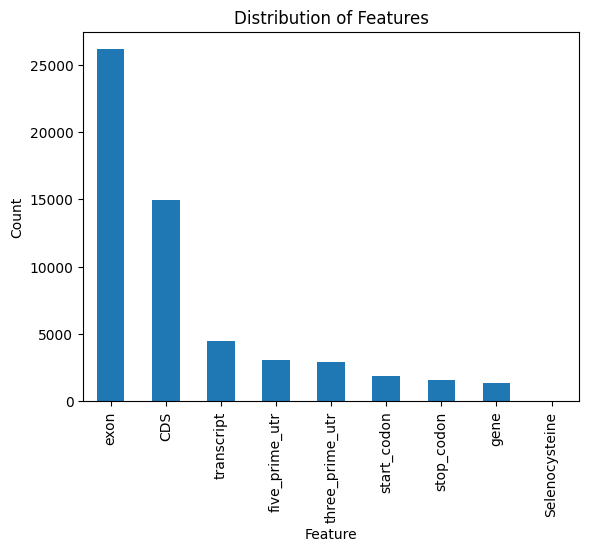

Aggregated data for:
                           gene_biotype         start              \
                                                mean      median   
0                            IG_C_gene  2.290632e+07  22903659.0   
1                      IG_C_pseudogene  2.666052e+07  22919535.0   
2                            IG_J_gene  2.290891e+07  22910574.0   
3                            IG_V_gene  2.251145e+07  22431958.0   
4                      IG_V_pseudogene  2.211462e+07  22425821.0   
5                                  TEC  3.901155e+07  41781320.5   
6                        antisense_RNA  3.346153e+07  32783177.0   
7                              lincRNA  3.200090e+07  30976515.0   
8                                miRNA  3.318420e+07  32529024.5   
9                             misc_RNA  3.006405e+07  28473366.5   
10              polymorphic_pseudogene  3.306013e+07  33060130.5   
11                processed_pseudogene  2.871366e+07  25647261.0   
12                processe

In [14]:
# Main pipeline
bucket_name = "sg-nex-data"
file_key = "data/data_tutorial/annotations/hg38_chr22.gtf"

gtf_data = load_gtf_data(bucket_name, file_key)
if gtf_data:
    gtf_df = parse_gtf_data(gtf_data)
    gtf_df = clean_data(gtf_df)
    validate_data(gtf_df)
    explore_data(gtf_df)
    genes_df = filter_genes(gtf_df)
    genes_df = extract_attributes(genes_df)
    genes_df = normalize_data(genes_df)
    agg_df = aggregate_data(genes_df)
    long_genes_df = filter_long_genes(genes_df)
    save_data(genes_df, f"data/filtered_chr22_genes.csv")
    save_data(long_genes_df, f"data/long_chr22_genes.csv")

## **Conclusion**

We hope to present this as a testament to the power of modern data engineering. By seamlessly integrating cloud-based storage, efficient retrieval strategies, and structured data transformations, we unlock the potential hidden within various datasets. 

The techniques showcased here lay the groundwork for further analytics and machine learning to be performed, pushing the boundaries of what’s possible in genomic research and beyond. With the right tools and methodologies, data engineers wield the power to turn raw information into groundbreaking discoveries.